In [ ]:
# windows with cuda 12.6
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [26]:
!uv pip install jupyterlab-vim jupyterlab-execute-time

Using Python 3.12.3 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Resolved 94 packages in 46ms
Installed 2 packages in 25ms
 + jupyterlab-execute-time==3.2.0
 + jupyterlab-vim==4.1.4


In [1]:
from pathlib import Path
import fastplotlib as fpl
import numpy as np
import os
import sys
import masknmf
import tifffile
%load_ext autoreload

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [2]:
fpath = Path(r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled\plane_07_mk301.tiff")
data = tifffile.memmap(fpath)
data.shape

(64594, 448, 448)

RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='448.0px', css_width='448.0px')
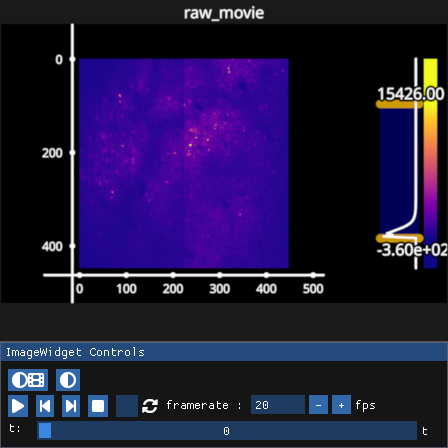

In [3]:
iw = fpl.ImageWidget(data=[data], names=["raw_movie"], figure_kwargs={"size": (data.shape[-1], data.shape[-2])})
iw.show()

In [4]:
iw.close()

# Define a rigid motion correction strategy. Optionally provide a template as a 2D torch.Tensor

In [5]:
max_rigid_shifts = [3, 3]
template = None
rigid_strategy = masknmf.RigidMotionCorrection(max_rigid_shifts, template = template)

# If template is not provided, run the general template update procedure below

In [6]:
rigid_strategy = masknmf.compute_template(data,
                                          rigid_strategy, 
                                          device = "cpu")

100%|██████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


# Define a motion correction array, which lazily loads motion corrected frames aligned via the registation_strategy

In [7]:
moco_results = masknmf.RegistrationArray(data,
                                         rigid_strategy,
                                         device = "cpu")

In [8]:
moco_results.shape

(64594, 448, 448)

In [13]:
type(moco_results)

masknmf.motion_correction.registration_arrays.RegistrationArray

In [3]:
save_path = Path("../data").resolve()
save_path.mkdir(exist_ok=True)

In [18]:
import numpy as np

# 4 min with batch of 100, 1 min with batch of 500
def lazy_to_tiff(lazy_array, save_path, batch_size=500):
    n_frames = lazy_array.shape[0]
    with tifffile.TiffWriter(save_path, bigtiff=True) as tif:
        for start in range(0, n_frames, batch_size):
            end = min(start + batch_size, n_frames)
            batch = lazy_array[start:end]
            for frame in batch:
                tif.write(
                    frame.astype(np.float32),
                    contiguous=True
                )

In [4]:
save_name = save_path.joinpath("plane_07_reg2.tiff")
# lazy_to_tiff(moco_results, save_name)

In [ ]:
# not working with full array
frame = moco_results[0:200, ...]
fpl.ImageWidget(data=[frame]).show()

# Visualize the raw vs. registered data via fastplotlib

In [ ]:
iw = fpl.ImageWidget(data = [data[::4], moco_results[::4]])
iw.cmap = "gray"
iw.show()

## demixing

In [5]:
data = tifffile.memmap(save_name)
data.shape

(64594, 448, 448)

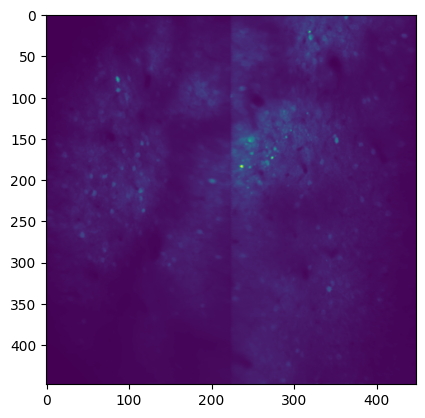

In [22]:
import matplotlib.pyplot as plt

plt.imshow(np.mean(data, axis=0))

In [6]:
pmd_obj = masknmf.compression.pmd_batch(data,
                                        [64, 64], #This specifies how we partition the full FOV 
                                        [10, 10], #This specifies by how many pixels the partitions overlap
                                        [32, 32], #This is the generic PMD compression parameter (block size for the actual compression)
                                        data.shape[0], #Number of frames we use to compress each block
                                        max_components = 10,
                                        background_rank = 10,
                                        device = "cuda"
)

[25-04-28 19:14:51]: Processing 0:64 to 0:64
[25-04-28 19:14:51]: Starting compression
[25-04-28 19:14:51]: sampled from the following regions: [0]
[25-04-28 19:14:51]: We are initializing on a total of 64594 frames
[25-04-28 19:14:52]: Approximating full FOV basis terms
[25-04-28 19:14:52]: Loading data to estimate complete spatial basis
[25-04-28 19:14:53]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 63.56it/s]

[25-04-28 19:14:57]: Running Blockwise Decompositions


[25-04-28 19:14:57]: Constructed U matrix. Rank of U is 40
[25-04-28 19:14:57]: PMD Objected constructed
[25-04-28 19:14:57]: Processing 0:64 to 54:118
[25-04-28 19:14:57]: Starting compression
[25-04-28 19:14:57]: sampled from the following regions: [0]
[25-04-28 19:14:57]: We are initializing on a total of 64594 frames
[25-04-28 19:14:58]: Approximating full FOV basis terms
[25-04-28 19:14:58]: Loading data to estimate complete spatial basis
[25-04-28 19:14:58]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.63it/s]

[25-04-28 19:15:02]: Running Blockwise Decompositions


[25-04-28 19:15:02]: Constructed U matrix. Rank of U is 57
[25-04-28 19:15:02]: PMD Objected constructed
[25-04-28 19:15:03]: Processing 0:64 to 108:172
[25-04-28 19:15:03]: Starting compression
[25-04-28 19:15:03]: sampled from the following regions: [0]
[25-04-28 19:15:03]: We are initializing on a total of 64594 frames
[25-04-28 19:15:03]: Approximating full FOV basis terms
[25-04-28 19:15:03]: Loading data to estimate complete spatial basis
[25-04-28 19:15:03]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.14it/s]

[25-04-28 19:15:07]: Running Blockwise Decompositions


[25-04-28 19:15:07]: Constructed U matrix. Rank of U is 82
[25-04-28 19:15:07]: PMD Objected constructed
[25-04-28 19:15:08]: Processing 0:64 to 162:226
[25-04-28 19:15:08]: Starting compression
[25-04-28 19:15:08]: sampled from the following regions: [0]
[25-04-28 19:15:08]: We are initializing on a total of 64594 frames
[25-04-28 19:15:08]: Approximating full FOV basis terms
[25-04-28 19:15:08]: Loading data to estimate complete spatial basis
[25-04-28 19:15:08]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.53it/s]

[25-04-28 19:15:12]: Running Blockwise Decompositions


[25-04-28 19:15:12]: Constructed U matrix. Rank of U is 72
[25-04-28 19:15:12]: PMD Objected constructed
[25-04-28 19:15:13]: Processing 0:64 to 216:280
[25-04-28 19:15:13]: Starting compression
[25-04-28 19:15:13]: sampled from the following regions: [0]
[25-04-28 19:15:13]: We are initializing on a total of 64594 frames
[25-04-28 19:15:13]: Approximating full FOV basis terms
[25-04-28 19:15:13]: Loading data to estimate complete spatial basis
[25-04-28 19:15:13]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.00it/s]

[25-04-28 19:15:17]: Running Blockwise Decompositions


[25-04-28 19:15:17]: Constructed U matrix. Rank of U is 63
[25-04-28 19:15:18]: PMD Objected constructed
[25-04-28 19:15:18]: Processing 0:64 to 270:334
[25-04-28 19:15:18]: Starting compression
[25-04-28 19:15:18]: sampled from the following regions: [0]
[25-04-28 19:15:18]: We are initializing on a total of 64594 frames
[25-04-28 19:15:18]: Approximating full FOV basis terms
[25-04-28 19:15:18]: Loading data to estimate complete spatial basis
[25-04-28 19:15:18]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.20it/s]

[25-04-28 19:15:22]: Running Blockwise Decompositions


[25-04-28 19:15:22]: Constructed U matrix. Rank of U is 73
[25-04-28 19:15:22]: PMD Objected constructed
[25-04-28 19:15:23]: Processing 0:64 to 324:388
[25-04-28 19:15:23]: Starting compression
[25-04-28 19:15:23]: sampled from the following regions: [0]
[25-04-28 19:15:23]: We are initializing on a total of 64594 frames
[25-04-28 19:15:23]: Approximating full FOV basis terms
[25-04-28 19:15:23]: Loading data to estimate complete spatial basis
[25-04-28 19:15:23]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.26it/s]

[25-04-28 19:15:27]: Running Blockwise Decompositions


[25-04-28 19:15:27]: Constructed U matrix. Rank of U is 77
[25-04-28 19:15:27]: PMD Objected constructed
[25-04-28 19:15:28]: Processing 0:64 to 378:442
[25-04-28 19:15:28]: Starting compression
[25-04-28 19:15:28]: sampled from the following regions: [0]
[25-04-28 19:15:28]: We are initializing on a total of 64594 frames
[25-04-28 19:15:28]: Approximating full FOV basis terms
[25-04-28 19:15:28]: Loading data to estimate complete spatial basis
[25-04-28 19:15:28]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.81it/s]

[25-04-28 19:15:32]: Running Blockwise Decompositions


[25-04-28 19:15:32]: Constructed U matrix. Rank of U is 78
[25-04-28 19:15:32]: PMD Objected constructed
[25-04-28 19:15:33]: Processing 0:64 to 410:448
[25-04-28 19:15:33]: Starting compression
[25-04-28 19:15:33]: sampled from the following regions: [0]
[25-04-28 19:15:33]: We are initializing on a total of 64594 frames
[25-04-28 19:15:33]: Approximating full FOV basis terms
[25-04-28 19:15:33]: Loading data to estimate complete spatial basis
[25-04-28 19:15:33]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.02it/s]

[25-04-28 19:15:37]: Running Blockwise Decompositions


[25-04-28 19:15:37]: Constructed U matrix. Rank of U is 52
[25-04-28 19:15:37]: PMD Objected constructed
[25-04-28 19:15:37]: Processing 54:118 to 0:64
[25-04-28 19:15:37]: Starting compression
[25-04-28 19:15:37]: sampled from the following regions: [0]
[25-04-28 19:15:37]: We are initializing on a total of 64594 frames
[25-04-28 19:15:38]: Approximating full FOV basis terms
[25-04-28 19:15:38]: Loading data to estimate complete spatial basis
[25-04-28 19:15:38]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.53it/s]

[25-04-28 19:15:42]: Running Blockwise Decompositions


[25-04-28 19:15:42]: Constructed U matrix. Rank of U is 45
[25-04-28 19:15:42]: PMD Objected constructed
[25-04-28 19:15:43]: Processing 54:118 to 54:118
[25-04-28 19:15:43]: Starting compression
[25-04-28 19:15:43]: sampled from the following regions: [0]
[25-04-28 19:15:43]: We are initializing on a total of 64594 frames
[25-04-28 19:15:43]: Approximating full FOV basis terms
[25-04-28 19:15:43]: Loading data to estimate complete spatial basis
[25-04-28 19:15:43]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.62it/s]

[25-04-28 19:15:47]: Running Blockwise Decompositions


[25-04-28 19:15:47]: Constructed U matrix. Rank of U is 46
[25-04-28 19:15:47]: PMD Objected constructed
[25-04-28 19:15:48]: Processing 54:118 to 108:172
[25-04-28 19:15:48]: Starting compression
[25-04-28 19:15:48]: sampled from the following regions: [0]
[25-04-28 19:15:48]: We are initializing on a total of 64594 frames
[25-04-28 19:15:48]: Approximating full FOV basis terms
[25-04-28 19:15:48]: Loading data to estimate complete spatial basis
[25-04-28 19:15:48]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.90it/s]

[25-04-28 19:15:52]: Running Blockwise Decompositions


[25-04-28 19:15:52]: Constructed U matrix. Rank of U is 73
[25-04-28 19:15:52]: PMD Objected constructed
[25-04-28 19:15:53]: Processing 54:118 to 162:226
[25-04-28 19:15:53]: Starting compression
[25-04-28 19:15:53]: sampled from the following regions: [0]
[25-04-28 19:15:53]: We are initializing on a total of 64594 frames
[25-04-28 19:15:53]: Approximating full FOV basis terms
[25-04-28 19:15:53]: Loading data to estimate complete spatial basis
[25-04-28 19:15:53]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 65.72it/s]

[25-04-28 19:15:57]: Running Blockwise Decompositions


[25-04-28 19:15:57]: Constructed U matrix. Rank of U is 92
[25-04-28 19:15:57]: PMD Objected constructed
[25-04-28 19:15:57]: Processing 54:118 to 216:280
[25-04-28 19:15:57]: Starting compression
[25-04-28 19:15:58]: sampled from the following regions: [0]
[25-04-28 19:15:58]: We are initializing on a total of 64594 frames
[25-04-28 19:15:58]: Approximating full FOV basis terms
[25-04-28 19:15:58]: Loading data to estimate complete spatial basis
[25-04-28 19:15:58]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.19it/s]

[25-04-28 19:16:02]: Running Blockwise Decompositions


[25-04-28 19:16:02]: Constructed U matrix. Rank of U is 61
[25-04-28 19:16:03]: PMD Objected constructed
[25-04-28 19:16:03]: Processing 54:118 to 270:334
[25-04-28 19:16:03]: Starting compression
[25-04-28 19:16:03]: sampled from the following regions: [0]
[25-04-28 19:16:03]: We are initializing on a total of 64594 frames
[25-04-28 19:16:03]: Approximating full FOV basis terms
[25-04-28 19:16:03]: Loading data to estimate complete spatial basis
[25-04-28 19:16:03]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.26it/s]

[25-04-28 19:16:07]: Running Blockwise Decompositions


[25-04-28 19:16:08]: Constructed U matrix. Rank of U is 59
[25-04-28 19:16:08]: PMD Objected constructed
[25-04-28 19:16:08]: Processing 54:118 to 324:388
[25-04-28 19:16:08]: Starting compression
[25-04-28 19:16:08]: sampled from the following regions: [0]
[25-04-28 19:16:08]: We are initializing on a total of 64594 frames
[25-04-28 19:16:08]: Approximating full FOV basis terms
[25-04-28 19:16:08]: Loading data to estimate complete spatial basis
[25-04-28 19:16:08]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.05it/s]

[25-04-28 19:16:12]: Running Blockwise Decompositions


[25-04-28 19:16:13]: Constructed U matrix. Rank of U is 56
[25-04-28 19:16:13]: PMD Objected constructed
[25-04-28 19:16:13]: Processing 54:118 to 378:442
[25-04-28 19:16:13]: Starting compression
[25-04-28 19:16:13]: sampled from the following regions: [0]
[25-04-28 19:16:13]: We are initializing on a total of 64594 frames
[25-04-28 19:16:13]: Approximating full FOV basis terms
[25-04-28 19:16:13]: Loading data to estimate complete spatial basis
[25-04-28 19:16:13]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.26it/s]

[25-04-28 19:16:17]: Running Blockwise Decompositions


[25-04-28 19:16:18]: Constructed U matrix. Rank of U is 47
[25-04-28 19:16:18]: PMD Objected constructed
[25-04-28 19:16:18]: Processing 54:118 to 410:448
[25-04-28 19:16:18]: Starting compression
[25-04-28 19:16:18]: sampled from the following regions: [0]
[25-04-28 19:16:18]: We are initializing on a total of 64594 frames
[25-04-28 19:16:18]: Approximating full FOV basis terms
[25-04-28 19:16:18]: Loading data to estimate complete spatial basis
[25-04-28 19:16:18]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.41it/s]

[25-04-28 19:16:22]: Running Blockwise Decompositions


[25-04-28 19:16:22]: Constructed U matrix. Rank of U is 33
[25-04-28 19:16:22]: PMD Objected constructed
[25-04-28 19:16:22]: Processing 108:172 to 0:64
[25-04-28 19:16:22]: Starting compression
[25-04-28 19:16:22]: sampled from the following regions: [0]
[25-04-28 19:16:22]: We are initializing on a total of 64594 frames
[25-04-28 19:16:23]: Approximating full FOV basis terms
[25-04-28 19:16:23]: Loading data to estimate complete spatial basis
[25-04-28 19:16:23]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.70it/s]

[25-04-28 19:16:27]: Running Blockwise Decompositions


[25-04-28 19:16:28]: Constructed U matrix. Rank of U is 59
[25-04-28 19:16:28]: PMD Objected constructed
[25-04-28 19:16:28]: Processing 108:172 to 54:118
[25-04-28 19:16:28]: Starting compression
[25-04-28 19:16:28]: sampled from the following regions: [0]
[25-04-28 19:16:28]: We are initializing on a total of 64594 frames
[25-04-28 19:16:28]: Approximating full FOV basis terms
[25-04-28 19:16:28]: Loading data to estimate complete spatial basis
[25-04-28 19:16:28]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.71it/s]

[25-04-28 19:16:32]: Running Blockwise Decompositions


[25-04-28 19:16:33]: Constructed U matrix. Rank of U is 72
[25-04-28 19:16:33]: PMD Objected constructed
[25-04-28 19:16:33]: Processing 108:172 to 108:172
[25-04-28 19:16:33]: Starting compression
[25-04-28 19:16:33]: sampled from the following regions: [0]
[25-04-28 19:16:33]: We are initializing on a total of 64594 frames
[25-04-28 19:16:33]: Approximating full FOV basis terms
[25-04-28 19:16:33]: Loading data to estimate complete spatial basis
[25-04-28 19:16:33]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.61it/s]

[25-04-28 19:16:37]: Running Blockwise Decompositions


[25-04-28 19:16:38]: Constructed U matrix. Rank of U is 76
[25-04-28 19:16:38]: PMD Objected constructed
[25-04-28 19:16:38]: Processing 108:172 to 162:226
[25-04-28 19:16:38]: Starting compression
[25-04-28 19:16:38]: sampled from the following regions: [0]
[25-04-28 19:16:38]: We are initializing on a total of 64594 frames
[25-04-28 19:16:38]: Approximating full FOV basis terms
[25-04-28 19:16:38]: Loading data to estimate complete spatial basis
[25-04-28 19:16:38]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.94it/s]

[25-04-28 19:16:42]: Running Blockwise Decompositions


[25-04-28 19:16:43]: Constructed U matrix. Rank of U is 65
[25-04-28 19:16:43]: PMD Objected constructed
[25-04-28 19:16:43]: Processing 108:172 to 216:280
[25-04-28 19:16:43]: Starting compression
[25-04-28 19:16:43]: sampled from the following regions: [0]
[25-04-28 19:16:43]: We are initializing on a total of 64594 frames
[25-04-28 19:16:43]: Approximating full FOV basis terms
[25-04-28 19:16:43]: Loading data to estimate complete spatial basis
[25-04-28 19:16:43]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.94it/s]

[25-04-28 19:16:47]: Running Blockwise Decompositions


[25-04-28 19:16:48]: Constructed U matrix. Rank of U is 59
[25-04-28 19:16:48]: PMD Objected constructed
[25-04-28 19:16:48]: Processing 108:172 to 270:334
[25-04-28 19:16:48]: Starting compression
[25-04-28 19:16:48]: sampled from the following regions: [0]
[25-04-28 19:16:48]: We are initializing on a total of 64594 frames
[25-04-28 19:16:48]: Approximating full FOV basis terms
[25-04-28 19:16:48]: Loading data to estimate complete spatial basis
[25-04-28 19:16:48]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.83it/s]

[25-04-28 19:16:52]: Running Blockwise Decompositions


[25-04-28 19:16:53]: Constructed U matrix. Rank of U is 40
[25-04-28 19:16:53]: PMD Objected constructed
[25-04-28 19:16:53]: Processing 108:172 to 324:388
[25-04-28 19:16:53]: Starting compression
[25-04-28 19:16:53]: sampled from the following regions: [0]
[25-04-28 19:16:53]: We are initializing on a total of 64594 frames
[25-04-28 19:16:53]: Approximating full FOV basis terms
[25-04-28 19:16:53]: Loading data to estimate complete spatial basis
[25-04-28 19:16:54]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.56it/s]

[25-04-28 19:16:57]: Running Blockwise Decompositions


[25-04-28 19:16:58]: Constructed U matrix. Rank of U is 54
[25-04-28 19:16:58]: PMD Objected constructed
[25-04-28 19:16:58]: Processing 108:172 to 378:442
[25-04-28 19:16:58]: Starting compression
[25-04-28 19:16:58]: sampled from the following regions: [0]
[25-04-28 19:16:58]: We are initializing on a total of 64594 frames
[25-04-28 19:16:58]: Approximating full FOV basis terms
[25-04-28 19:16:58]: Loading data to estimate complete spatial basis
[25-04-28 19:16:59]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.59it/s]


[25-04-28 19:17:02]: Running Blockwise Decompositions
[25-04-28 19:17:03]: Constructed U matrix. Rank of U is 49
[25-04-28 19:17:03]: PMD Objected constructed
[25-04-28 19:17:03]: Processing 108:172 to 410:448
[25-04-28 19:17:03]: Starting compression
[25-04-28 19:17:03]: sampled from the following regions: [0]
[25-04-28 19:17:03]: We are initializing on a total of 64594 frames
[25-04-28 19:17:03]: Approximating full FOV basis terms
[25-04-28 19:17:03]: Loading data to estimate complete spatial basis
[25-04-28 19:17:03]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.68it/s]

[25-04-28 19:17:07]: Running Blockwise Decompositions


[25-04-28 19:17:08]: Constructed U matrix. Rank of U is 35
[25-04-28 19:17:08]: PMD Objected constructed
[25-04-28 19:17:08]: Processing 162:226 to 0:64
[25-04-28 19:17:08]: Starting compression
[25-04-28 19:17:08]: sampled from the following regions: [0]
[25-04-28 19:17:08]: We are initializing on a total of 64594 frames
[25-04-28 19:17:08]: Approximating full FOV basis terms
[25-04-28 19:17:08]: Loading data to estimate complete spatial basis
[25-04-28 19:17:09]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.76it/s]

[25-04-28 19:17:13]: Running Blockwise Decompositions


[25-04-28 19:17:13]: Constructed U matrix. Rank of U is 66
[25-04-28 19:17:13]: PMD Objected constructed
[25-04-28 19:17:13]: Processing 162:226 to 54:118
[25-04-28 19:17:13]: Starting compression
[25-04-28 19:17:13]: sampled from the following regions: [0]
[25-04-28 19:17:13]: We are initializing on a total of 64594 frames
[25-04-28 19:17:13]: Approximating full FOV basis terms
[25-04-28 19:17:13]: Loading data to estimate complete spatial basis
[25-04-28 19:17:14]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.69it/s]

[25-04-28 19:17:18]: Running Blockwise Decompositions


[25-04-28 19:17:18]: Constructed U matrix. Rank of U is 67
[25-04-28 19:17:18]: PMD Objected constructed
[25-04-28 19:17:18]: Processing 162:226 to 108:172
[25-04-28 19:17:18]: Starting compression
[25-04-28 19:17:18]: sampled from the following regions: [0]
[25-04-28 19:17:18]: We are initializing on a total of 64594 frames
[25-04-28 19:17:18]: Approximating full FOV basis terms
[25-04-28 19:17:18]: Loading data to estimate complete spatial basis
[25-04-28 19:17:19]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.52it/s]

[25-04-28 19:17:23]: Running Blockwise Decompositions


[25-04-28 19:17:23]: Constructed U matrix. Rank of U is 69
[25-04-28 19:17:23]: PMD Objected constructed
[25-04-28 19:17:23]: Processing 162:226 to 162:226
[25-04-28 19:17:23]: Starting compression
[25-04-28 19:17:23]: sampled from the following regions: [0]
[25-04-28 19:17:23]: We are initializing on a total of 64594 frames
[25-04-28 19:17:23]: Approximating full FOV basis terms
[25-04-28 19:17:23]: Loading data to estimate complete spatial basis
[25-04-28 19:17:24]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.64it/s]

[25-04-28 19:17:28]: Running Blockwise Decompositions


[25-04-28 19:17:28]: Constructed U matrix. Rank of U is 59
[25-04-28 19:17:28]: PMD Objected constructed
[25-04-28 19:17:28]: Processing 162:226 to 216:280
[25-04-28 19:17:28]: Starting compression
[25-04-28 19:17:28]: sampled from the following regions: [0]
[25-04-28 19:17:28]: We are initializing on a total of 64594 frames
[25-04-28 19:17:29]: Approximating full FOV basis terms
[25-04-28 19:17:29]: Loading data to estimate complete spatial basis
[25-04-28 19:17:29]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.62it/s]

[25-04-28 19:17:33]: Running Blockwise Decompositions


[25-04-28 19:17:33]: Constructed U matrix. Rank of U is 57
[25-04-28 19:17:33]: PMD Objected constructed
[25-04-28 19:17:33]: Processing 162:226 to 270:334
[25-04-28 19:17:33]: Starting compression
[25-04-28 19:17:33]: sampled from the following regions: [0]
[25-04-28 19:17:33]: We are initializing on a total of 64594 frames
[25-04-28 19:17:34]: Approximating full FOV basis terms
[25-04-28 19:17:34]: Loading data to estimate complete spatial basis
[25-04-28 19:17:34]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.62it/s]

[25-04-28 19:17:38]: Running Blockwise Decompositions


[25-04-28 19:17:38]: Constructed U matrix. Rank of U is 48
[25-04-28 19:17:38]: PMD Objected constructed
[25-04-28 19:17:38]: Processing 162:226 to 324:388
[25-04-28 19:17:38]: Starting compression
[25-04-28 19:17:38]: sampled from the following regions: [0]
[25-04-28 19:17:38]: We are initializing on a total of 64594 frames
[25-04-28 19:17:39]: Approximating full FOV basis terms
[25-04-28 19:17:39]: Loading data to estimate complete spatial basis
[25-04-28 19:17:39]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.54it/s]

[25-04-28 19:17:43]: Running Blockwise Decompositions


[25-04-28 19:17:43]: Constructed U matrix. Rank of U is 45
[25-04-28 19:17:43]: PMD Objected constructed
[25-04-28 19:17:43]: Processing 162:226 to 378:442
[25-04-28 19:17:43]: Starting compression
[25-04-28 19:17:43]: sampled from the following regions: [0]
[25-04-28 19:17:43]: We are initializing on a total of 64594 frames
[25-04-28 19:17:44]: Approximating full FOV basis terms
[25-04-28 19:17:44]: Loading data to estimate complete spatial basis
[25-04-28 19:17:44]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.62it/s]

[25-04-28 19:17:48]: Running Blockwise Decompositions


[25-04-28 19:17:48]: Constructed U matrix. Rank of U is 51
[25-04-28 19:17:48]: PMD Objected constructed
[25-04-28 19:17:49]: Processing 162:226 to 410:448
[25-04-28 19:17:49]: Starting compression
[25-04-28 19:17:49]: sampled from the following regions: [0]
[25-04-28 19:17:49]: We are initializing on a total of 64594 frames
[25-04-28 19:17:49]: Approximating full FOV basis terms
[25-04-28 19:17:49]: Loading data to estimate complete spatial basis
[25-04-28 19:17:49]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.63it/s]

[25-04-28 19:17:53]: Running Blockwise Decompositions


[25-04-28 19:17:53]: Constructed U matrix. Rank of U is 34
[25-04-28 19:17:53]: PMD Objected constructed
[25-04-28 19:17:53]: Processing 216:280 to 0:64
[25-04-28 19:17:53]: Starting compression
[25-04-28 19:17:53]: sampled from the following regions: [0]
[25-04-28 19:17:53]: We are initializing on a total of 64594 frames
[25-04-28 19:17:54]: Approximating full FOV basis terms
[25-04-28 19:17:54]: Loading data to estimate complete spatial basis
[25-04-28 19:17:54]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.52it/s]

[25-04-28 19:17:58]: Running Blockwise Decompositions


[25-04-28 19:17:58]: Constructed U matrix. Rank of U is 63
[25-04-28 19:17:58]: PMD Objected constructed
[25-04-28 19:17:59]: Processing 216:280 to 54:118
[25-04-28 19:17:59]: Starting compression
[25-04-28 19:17:59]: sampled from the following regions: [0]
[25-04-28 19:17:59]: We are initializing on a total of 64594 frames
[25-04-28 19:17:59]: Approximating full FOV basis terms
[25-04-28 19:17:59]: Loading data to estimate complete spatial basis
[25-04-28 19:17:59]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.34it/s]

[25-04-28 19:18:03]: Running Blockwise Decompositions


[25-04-28 19:18:03]: Constructed U matrix. Rank of U is 69
[25-04-28 19:18:04]: PMD Objected constructed
[25-04-28 19:18:04]: Processing 216:280 to 108:172
[25-04-28 19:18:04]: Starting compression
[25-04-28 19:18:04]: sampled from the following regions: [0]
[25-04-28 19:18:04]: We are initializing on a total of 64594 frames
[25-04-28 19:18:04]: Approximating full FOV basis terms
[25-04-28 19:18:04]: Loading data to estimate complete spatial basis
[25-04-28 19:18:04]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.68it/s]

[25-04-28 19:18:08]: Running Blockwise Decompositions


[25-04-28 19:18:09]: Constructed U matrix. Rank of U is 56
[25-04-28 19:18:09]: PMD Objected constructed
[25-04-28 19:18:09]: Processing 216:280 to 162:226
[25-04-28 19:18:09]: Starting compression
[25-04-28 19:18:09]: sampled from the following regions: [0]
[25-04-28 19:18:09]: We are initializing on a total of 64594 frames
[25-04-28 19:18:09]: Approximating full FOV basis terms
[25-04-28 19:18:09]: Loading data to estimate complete spatial basis
[25-04-28 19:18:09]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.63it/s]

[25-04-28 19:18:13]: Running Blockwise Decompositions


[25-04-28 19:18:14]: Constructed U matrix. Rank of U is 69
[25-04-28 19:18:14]: PMD Objected constructed
[25-04-28 19:18:14]: Processing 216:280 to 216:280
[25-04-28 19:18:14]: Starting compression
[25-04-28 19:18:14]: sampled from the following regions: [0]
[25-04-28 19:18:14]: We are initializing on a total of 64594 frames
[25-04-28 19:18:14]: Approximating full FOV basis terms
[25-04-28 19:18:14]: Loading data to estimate complete spatial basis
[25-04-28 19:18:14]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.61it/s]


[25-04-28 19:18:18]: Running Blockwise Decompositions
[25-04-28 19:18:19]: Constructed U matrix. Rank of U is 47
[25-04-28 19:18:19]: PMD Objected constructed
[25-04-28 19:18:19]: Processing 216:280 to 270:334
[25-04-28 19:18:19]: Starting compression
[25-04-28 19:18:19]: sampled from the following regions: [0]
[25-04-28 19:18:19]: We are initializing on a total of 64594 frames
[25-04-28 19:18:19]: Approximating full FOV basis terms
[25-04-28 19:18:19]: Loading data to estimate complete spatial basis
[25-04-28 19:18:19]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.56it/s]

[25-04-28 19:18:23]: Running Blockwise Decompositions


[25-04-28 19:18:24]: Constructed U matrix. Rank of U is 44
[25-04-28 19:18:24]: PMD Objected constructed
[25-04-28 19:18:24]: Processing 216:280 to 324:388
[25-04-28 19:18:24]: Starting compression
[25-04-28 19:18:24]: sampled from the following regions: [0]
[25-04-28 19:18:24]: We are initializing on a total of 64594 frames
[25-04-28 19:18:24]: Approximating full FOV basis terms
[25-04-28 19:18:24]: Loading data to estimate complete spatial basis
[25-04-28 19:18:24]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.66it/s]

[25-04-28 19:18:28]: Running Blockwise Decompositions


[25-04-28 19:18:29]: Constructed U matrix. Rank of U is 48
[25-04-28 19:18:29]: PMD Objected constructed
[25-04-28 19:18:29]: Processing 216:280 to 378:442
[25-04-28 19:18:29]: Starting compression
[25-04-28 19:18:29]: sampled from the following regions: [0]
[25-04-28 19:18:29]: We are initializing on a total of 64594 frames
[25-04-28 19:18:29]: Approximating full FOV basis terms
[25-04-28 19:18:29]: Loading data to estimate complete spatial basis
[25-04-28 19:18:29]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.45it/s]

[25-04-28 19:18:33]: Running Blockwise Decompositions


[25-04-28 19:18:34]: Constructed U matrix. Rank of U is 59
[25-04-28 19:18:34]: PMD Objected constructed
[25-04-28 19:18:34]: Processing 216:280 to 410:448
[25-04-28 19:18:34]: Starting compression
[25-04-28 19:18:34]: sampled from the following regions: [0]
[25-04-28 19:18:34]: We are initializing on a total of 64594 frames
[25-04-28 19:18:34]: Approximating full FOV basis terms
[25-04-28 19:18:34]: Loading data to estimate complete spatial basis
[25-04-28 19:18:34]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.66it/s]

[25-04-28 19:18:38]: Running Blockwise Decompositions


[25-04-28 19:18:38]: Constructed U matrix. Rank of U is 39
[25-04-28 19:18:38]: PMD Objected constructed
[25-04-28 19:18:39]: Processing 270:334 to 0:64
[25-04-28 19:18:39]: Starting compression
[25-04-28 19:18:39]: sampled from the following regions: [0]
[25-04-28 19:18:39]: We are initializing on a total of 64594 frames
[25-04-28 19:18:39]: Approximating full FOV basis terms
[25-04-28 19:18:39]: Loading data to estimate complete spatial basis
[25-04-28 19:18:39]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.63it/s]

[25-04-28 19:18:43]: Running Blockwise Decompositions


[25-04-28 19:18:44]: Constructed U matrix. Rank of U is 52
[25-04-28 19:18:44]: PMD Objected constructed
[25-04-28 19:18:44]: Processing 270:334 to 54:118
[25-04-28 19:18:44]: Starting compression
[25-04-28 19:18:44]: sampled from the following regions: [0]
[25-04-28 19:18:44]: We are initializing on a total of 64594 frames
[25-04-28 19:18:44]: Approximating full FOV basis terms
[25-04-28 19:18:44]: Loading data to estimate complete spatial basis
[25-04-28 19:18:44]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.42it/s]

[25-04-28 19:18:48]: Running Blockwise Decompositions


[25-04-28 19:18:49]: Constructed U matrix. Rank of U is 56
[25-04-28 19:18:49]: PMD Objected constructed
[25-04-28 19:18:49]: Processing 270:334 to 108:172
[25-04-28 19:18:49]: Starting compression
[25-04-28 19:18:49]: sampled from the following regions: [0]
[25-04-28 19:18:49]: We are initializing on a total of 64594 frames
[25-04-28 19:18:49]: Approximating full FOV basis terms
[25-04-28 19:18:49]: Loading data to estimate complete spatial basis
[25-04-28 19:18:49]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.57it/s]

[25-04-28 19:18:53]: Running Blockwise Decompositions


[25-04-28 19:18:54]: Constructed U matrix. Rank of U is 61
[25-04-28 19:18:54]: PMD Objected constructed
[25-04-28 19:18:54]: Processing 270:334 to 162:226
[25-04-28 19:18:54]: Starting compression
[25-04-28 19:18:54]: sampled from the following regions: [0]
[25-04-28 19:18:54]: We are initializing on a total of 64594 frames
[25-04-28 19:18:54]: Approximating full FOV basis terms
[25-04-28 19:18:54]: Loading data to estimate complete spatial basis
[25-04-28 19:18:55]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.59it/s]

[25-04-28 19:18:58]: Running Blockwise Decompositions


[25-04-28 19:18:59]: Constructed U matrix. Rank of U is 52
[25-04-28 19:18:59]: PMD Objected constructed
[25-04-28 19:18:59]: Processing 270:334 to 216:280
[25-04-28 19:18:59]: Starting compression
[25-04-28 19:18:59]: sampled from the following regions: [0]
[25-04-28 19:18:59]: We are initializing on a total of 64594 frames
[25-04-28 19:18:59]: Approximating full FOV basis terms
[25-04-28 19:18:59]: Loading data to estimate complete spatial basis
[25-04-28 19:19:00]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.67it/s]

[25-04-28 19:19:03]: Running Blockwise Decompositions


[25-04-28 19:19:04]: Constructed U matrix. Rank of U is 49
[25-04-28 19:19:04]: PMD Objected constructed
[25-04-28 19:19:04]: Processing 270:334 to 270:334
[25-04-28 19:19:04]: Starting compression
[25-04-28 19:19:04]: sampled from the following regions: [0]
[25-04-28 19:19:04]: We are initializing on a total of 64594 frames
[25-04-28 19:19:04]: Approximating full FOV basis terms
[25-04-28 19:19:04]: Loading data to estimate complete spatial basis
[25-04-28 19:19:05]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.57it/s]

[25-04-28 19:19:09]: Running Blockwise Decompositions


[25-04-28 19:19:09]: Constructed U matrix. Rank of U is 49
[25-04-28 19:19:09]: PMD Objected constructed
[25-04-28 19:19:09]: Processing 270:334 to 324:388
[25-04-28 19:19:09]: Starting compression
[25-04-28 19:19:09]: sampled from the following regions: [0]
[25-04-28 19:19:09]: We are initializing on a total of 64594 frames
[25-04-28 19:19:09]: Approximating full FOV basis terms
[25-04-28 19:19:09]: Loading data to estimate complete spatial basis
[25-04-28 19:19:10]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.65it/s]

[25-04-28 19:19:14]: Running Blockwise Decompositions


[25-04-28 19:19:14]: Constructed U matrix. Rank of U is 63
[25-04-28 19:19:14]: PMD Objected constructed
[25-04-28 19:19:14]: Processing 270:334 to 378:442
[25-04-28 19:19:14]: Starting compression
[25-04-28 19:19:14]: sampled from the following regions: [0]
[25-04-28 19:19:14]: We are initializing on a total of 64594 frames
[25-04-28 19:19:14]: Approximating full FOV basis terms
[25-04-28 19:19:14]: Loading data to estimate complete spatial basis
[25-04-28 19:19:15]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.69it/s]

[25-04-28 19:19:19]: Running Blockwise Decompositions


[25-04-28 19:19:19]: Constructed U matrix. Rank of U is 41
[25-04-28 19:19:19]: PMD Objected constructed
[25-04-28 19:19:19]: Processing 270:334 to 410:448
[25-04-28 19:19:19]: Starting compression
[25-04-28 19:19:19]: sampled from the following regions: [0]
[25-04-28 19:19:19]: We are initializing on a total of 64594 frames
[25-04-28 19:19:19]: Approximating full FOV basis terms
[25-04-28 19:19:19]: Loading data to estimate complete spatial basis
[25-04-28 19:19:20]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.44it/s]

[25-04-28 19:19:23]: Running Blockwise Decompositions


[25-04-28 19:19:24]: Constructed U matrix. Rank of U is 31
[25-04-28 19:19:24]: PMD Objected constructed
[25-04-28 19:19:24]: Processing 324:388 to 0:64
[25-04-28 19:19:24]: Starting compression
[25-04-28 19:19:24]: sampled from the following regions: [0]
[25-04-28 19:19:24]: We are initializing on a total of 64594 frames
[25-04-28 19:19:24]: Approximating full FOV basis terms
[25-04-28 19:19:24]: Loading data to estimate complete spatial basis
[25-04-28 19:19:25]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.44it/s]

[25-04-28 19:19:29]: Running Blockwise Decompositions


[25-04-28 19:19:29]: Constructed U matrix. Rank of U is 44
[25-04-28 19:19:29]: PMD Objected constructed
[25-04-28 19:19:29]: Processing 324:388 to 54:118
[25-04-28 19:19:29]: Starting compression
[25-04-28 19:19:29]: sampled from the following regions: [0]
[25-04-28 19:19:29]: We are initializing on a total of 64594 frames
[25-04-28 19:19:29]: Approximating full FOV basis terms
[25-04-28 19:19:29]: Loading data to estimate complete spatial basis
[25-04-28 19:19:30]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.61it/s]

[25-04-28 19:19:34]: Running Blockwise Decompositions


[25-04-28 19:19:34]: Constructed U matrix. Rank of U is 34
[25-04-28 19:19:34]: PMD Objected constructed
[25-04-28 19:19:34]: Processing 324:388 to 108:172
[25-04-28 19:19:34]: Starting compression
[25-04-28 19:19:34]: sampled from the following regions: [0]
[25-04-28 19:19:34]: We are initializing on a total of 64594 frames
[25-04-28 19:19:34]: Approximating full FOV basis terms
[25-04-28 19:19:34]: Loading data to estimate complete spatial basis
[25-04-28 19:19:35]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.22it/s]

[25-04-28 19:19:39]: Running Blockwise Decompositions


[25-04-28 19:19:39]: Constructed U matrix. Rank of U is 36
[25-04-28 19:19:39]: PMD Objected constructed
[25-04-28 19:19:39]: Processing 324:388 to 162:226
[25-04-28 19:19:39]: Starting compression
[25-04-28 19:19:39]: sampled from the following regions: [0]
[25-04-28 19:19:39]: We are initializing on a total of 64594 frames
[25-04-28 19:19:40]: Approximating full FOV basis terms
[25-04-28 19:19:40]: Loading data to estimate complete spatial basis
[25-04-28 19:19:40]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.64it/s]

[25-04-28 19:19:44]: Running Blockwise Decompositions


[25-04-28 19:19:44]: Constructed U matrix. Rank of U is 48
[25-04-28 19:19:44]: PMD Objected constructed
[25-04-28 19:19:44]: Processing 324:388 to 216:280
[25-04-28 19:19:44]: Starting compression
[25-04-28 19:19:44]: sampled from the following regions: [0]
[25-04-28 19:19:44]: We are initializing on a total of 64594 frames
[25-04-28 19:19:45]: Approximating full FOV basis terms
[25-04-28 19:19:45]: Loading data to estimate complete spatial basis
[25-04-28 19:19:45]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.42it/s]

[25-04-28 19:19:49]: Running Blockwise Decompositions


[25-04-28 19:19:49]: Constructed U matrix. Rank of U is 44
[25-04-28 19:19:49]: PMD Objected constructed
[25-04-28 19:19:49]: Processing 324:388 to 270:334
[25-04-28 19:19:49]: Starting compression
[25-04-28 19:19:49]: sampled from the following regions: [0]
[25-04-28 19:19:49]: We are initializing on a total of 64594 frames
[25-04-28 19:19:50]: Approximating full FOV basis terms
[25-04-28 19:19:50]: Loading data to estimate complete spatial basis
[25-04-28 19:19:50]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.48it/s]

[25-04-28 19:19:54]: Running Blockwise Decompositions


[25-04-28 19:19:54]: Constructed U matrix. Rank of U is 43
[25-04-28 19:19:54]: PMD Objected constructed
[25-04-28 19:19:54]: Processing 324:388 to 324:388
[25-04-28 19:19:54]: Starting compression
[25-04-28 19:19:54]: sampled from the following regions: [0]
[25-04-28 19:19:54]: We are initializing on a total of 64594 frames
[25-04-28 19:19:55]: Approximating full FOV basis terms
[25-04-28 19:19:55]: Loading data to estimate complete spatial basis
[25-04-28 19:19:55]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.52it/s]

[25-04-28 19:19:59]: Running Blockwise Decompositions


[25-04-28 19:19:59]: Constructed U matrix. Rank of U is 55
[25-04-28 19:19:59]: PMD Objected constructed
[25-04-28 19:20:00]: Processing 324:388 to 378:442
[25-04-28 19:20:00]: Starting compression
[25-04-28 19:20:00]: sampled from the following regions: [0]
[25-04-28 19:20:00]: We are initializing on a total of 64594 frames
[25-04-28 19:20:00]: Approximating full FOV basis terms
[25-04-28 19:20:00]: Loading data to estimate complete spatial basis
[25-04-28 19:20:00]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.61it/s]

[25-04-28 19:20:04]: Running Blockwise Decompositions


[25-04-28 19:20:04]: Constructed U matrix. Rank of U is 54
[25-04-28 19:20:05]: PMD Objected constructed
[25-04-28 19:20:05]: Processing 324:388 to 410:448
[25-04-28 19:20:05]: Starting compression
[25-04-28 19:20:05]: sampled from the following regions: [0]
[25-04-28 19:20:05]: We are initializing on a total of 64594 frames
[25-04-28 19:20:05]: Approximating full FOV basis terms
[25-04-28 19:20:05]: Loading data to estimate complete spatial basis
[25-04-28 19:20:05]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.59it/s]

[25-04-28 19:20:09]: Running Blockwise Decompositions


[25-04-28 19:20:09]: Constructed U matrix. Rank of U is 30
[25-04-28 19:20:09]: PMD Objected constructed
[25-04-28 19:20:09]: Processing 378:442 to 0:64
[25-04-28 19:20:09]: Starting compression
[25-04-28 19:20:09]: sampled from the following regions: [0]
[25-04-28 19:20:09]: We are initializing on a total of 64594 frames
[25-04-28 19:20:10]: Approximating full FOV basis terms
[25-04-28 19:20:10]: Loading data to estimate complete spatial basis
[25-04-28 19:20:10]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.27it/s]

[25-04-28 19:20:14]: Running Blockwise Decompositions


[25-04-28 19:20:15]: Constructed U matrix. Rank of U is 30
[25-04-28 19:20:15]: PMD Objected constructed
[25-04-28 19:20:15]: Processing 378:442 to 54:118
[25-04-28 19:20:15]: Starting compression
[25-04-28 19:20:15]: sampled from the following regions: [0]
[25-04-28 19:20:15]: We are initializing on a total of 64594 frames
[25-04-28 19:20:15]: Approximating full FOV basis terms
[25-04-28 19:20:15]: Loading data to estimate complete spatial basis
[25-04-28 19:20:15]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.47it/s]

[25-04-28 19:20:19]: Running Blockwise Decompositions


[25-04-28 19:20:20]: Constructed U matrix. Rank of U is 28
[25-04-28 19:20:20]: PMD Objected constructed
[25-04-28 19:20:20]: Processing 378:442 to 108:172
[25-04-28 19:20:20]: Starting compression
[25-04-28 19:20:20]: sampled from the following regions: [0]
[25-04-28 19:20:20]: We are initializing on a total of 64594 frames
[25-04-28 19:20:20]: Approximating full FOV basis terms
[25-04-28 19:20:20]: Loading data to estimate complete spatial basis
[25-04-28 19:20:20]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.41it/s]

[25-04-28 19:20:24]: Running Blockwise Decompositions


[25-04-28 19:20:25]: Constructed U matrix. Rank of U is 28
[25-04-28 19:20:25]: PMD Objected constructed
[25-04-28 19:20:25]: Processing 378:442 to 162:226
[25-04-28 19:20:25]: Starting compression
[25-04-28 19:20:25]: sampled from the following regions: [0]
[25-04-28 19:20:25]: We are initializing on a total of 64594 frames
[25-04-28 19:20:25]: Approximating full FOV basis terms
[25-04-28 19:20:25]: Loading data to estimate complete spatial basis
[25-04-28 19:20:25]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.48it/s]

[25-04-28 19:20:29]: Running Blockwise Decompositions


[25-04-28 19:20:30]: Constructed U matrix. Rank of U is 36
[25-04-28 19:20:30]: PMD Objected constructed
[25-04-28 19:20:30]: Processing 378:442 to 216:280
[25-04-28 19:20:30]: Starting compression
[25-04-28 19:20:30]: sampled from the following regions: [0]
[25-04-28 19:20:30]: We are initializing on a total of 64594 frames
[25-04-28 19:20:30]: Approximating full FOV basis terms
[25-04-28 19:20:30]: Loading data to estimate complete spatial basis
[25-04-28 19:20:30]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.52it/s]

[25-04-28 19:20:34]: Running Blockwise Decompositions


[25-04-28 19:20:35]: Constructed U matrix. Rank of U is 47
[25-04-28 19:20:35]: PMD Objected constructed
[25-04-28 19:20:35]: Processing 378:442 to 270:334
[25-04-28 19:20:35]: Starting compression
[25-04-28 19:20:35]: sampled from the following regions: [0]
[25-04-28 19:20:35]: We are initializing on a total of 64594 frames
[25-04-28 19:20:35]: Approximating full FOV basis terms
[25-04-28 19:20:35]: Loading data to estimate complete spatial basis
[25-04-28 19:20:35]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.23it/s]

[25-04-28 19:20:39]: Running Blockwise Decompositions


[25-04-28 19:20:40]: Constructed U matrix. Rank of U is 49
[25-04-28 19:20:40]: PMD Objected constructed
[25-04-28 19:20:40]: Processing 378:442 to 324:388
[25-04-28 19:20:40]: Starting compression
[25-04-28 19:20:40]: sampled from the following regions: [0]
[25-04-28 19:20:40]: We are initializing on a total of 64594 frames
[25-04-28 19:20:40]: Approximating full FOV basis terms
[25-04-28 19:20:40]: Loading data to estimate complete spatial basis
[25-04-28 19:20:40]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.41it/s]

[25-04-28 19:20:44]: Running Blockwise Decompositions


[25-04-28 19:20:45]: Constructed U matrix. Rank of U is 50
[25-04-28 19:20:45]: PMD Objected constructed
[25-04-28 19:20:45]: Processing 378:442 to 378:442
[25-04-28 19:20:45]: Starting compression
[25-04-28 19:20:45]: sampled from the following regions: [0]
[25-04-28 19:20:45]: We are initializing on a total of 64594 frames
[25-04-28 19:20:45]: Approximating full FOV basis terms
[25-04-28 19:20:45]: Loading data to estimate complete spatial basis
[25-04-28 19:20:45]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.40it/s]

[25-04-28 19:20:49]: Running Blockwise Decompositions


[25-04-28 19:20:50]: Constructed U matrix. Rank of U is 37
[25-04-28 19:20:50]: PMD Objected constructed
[25-04-28 19:20:50]: Processing 378:442 to 410:448
[25-04-28 19:20:50]: Starting compression
[25-04-28 19:20:50]: sampled from the following regions: [0]
[25-04-28 19:20:50]: We are initializing on a total of 64594 frames
[25-04-28 19:20:50]: Approximating full FOV basis terms
[25-04-28 19:20:50]: Loading data to estimate complete spatial basis
[25-04-28 19:20:50]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.40it/s]

[25-04-28 19:20:54]: Running Blockwise Decompositions


[25-04-28 19:20:55]: Constructed U matrix. Rank of U is 30
[25-04-28 19:20:55]: PMD Objected constructed
[25-04-28 19:20:55]: Processing 410:448 to 0:64
[25-04-28 19:20:55]: Starting compression
[25-04-28 19:20:55]: sampled from the following regions: [0]
[25-04-28 19:20:55]: We are initializing on a total of 64594 frames
[25-04-28 19:20:55]: Approximating full FOV basis terms
[25-04-28 19:20:55]: Loading data to estimate complete spatial basis
[25-04-28 19:20:55]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.53it/s]

[25-04-28 19:20:59]: Running Blockwise Decompositions


[25-04-28 19:20:59]: Constructed U matrix. Rank of U is 22
[25-04-28 19:20:59]: PMD Objected constructed
[25-04-28 19:20:59]: Processing 410:448 to 54:118
[25-04-28 19:20:59]: Starting compression
[25-04-28 19:20:59]: sampled from the following regions: [0]
[25-04-28 19:20:59]: We are initializing on a total of 64594 frames
[25-04-28 19:20:59]: Approximating full FOV basis terms
[25-04-28 19:20:59]: Loading data to estimate complete spatial basis
[25-04-28 19:21:00]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.49it/s]

[25-04-28 19:21:03]: Running Blockwise Decompositions


[25-04-28 19:21:04]: Constructed U matrix. Rank of U is 26
[25-04-28 19:21:04]: PMD Objected constructed
[25-04-28 19:21:04]: Processing 410:448 to 108:172
[25-04-28 19:21:04]: Starting compression
[25-04-28 19:21:04]: sampled from the following regions: [0]
[25-04-28 19:21:04]: We are initializing on a total of 64594 frames
[25-04-28 19:21:04]: Approximating full FOV basis terms
[25-04-28 19:21:04]: Loading data to estimate complete spatial basis
[25-04-28 19:21:04]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.62it/s]

[25-04-28 19:21:08]: Running Blockwise Decompositions


[25-04-28 19:21:08]: Constructed U matrix. Rank of U is 26
[25-04-28 19:21:08]: PMD Objected constructed
[25-04-28 19:21:08]: Processing 410:448 to 162:226
[25-04-28 19:21:08]: Starting compression
[25-04-28 19:21:08]: sampled from the following regions: [0]
[25-04-28 19:21:08]: We are initializing on a total of 64594 frames
[25-04-28 19:21:09]: Approximating full FOV basis terms
[25-04-28 19:21:09]: Loading data to estimate complete spatial basis
[25-04-28 19:21:09]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.21it/s]

[25-04-28 19:21:13]: Running Blockwise Decompositions


[25-04-28 19:21:13]: Constructed U matrix. Rank of U is 26
[25-04-28 19:21:13]: PMD Objected constructed
[25-04-28 19:21:13]: Processing 410:448 to 216:280
[25-04-28 19:21:13]: Starting compression
[25-04-28 19:21:13]: sampled from the following regions: [0]
[25-04-28 19:21:13]: We are initializing on a total of 64594 frames
[25-04-28 19:21:13]: Approximating full FOV basis terms
[25-04-28 19:21:13]: Loading data to estimate complete spatial basis
[25-04-28 19:21:13]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.57it/s]

[25-04-28 19:21:17]: Running Blockwise Decompositions


[25-04-28 19:21:18]: Constructed U matrix. Rank of U is 36
[25-04-28 19:21:18]: PMD Objected constructed
[25-04-28 19:21:18]: Processing 410:448 to 270:334
[25-04-28 19:21:18]: Starting compression
[25-04-28 19:21:18]: sampled from the following regions: [0]
[25-04-28 19:21:18]: We are initializing on a total of 64594 frames
[25-04-28 19:21:18]: Approximating full FOV basis terms
[25-04-28 19:21:18]: Loading data to estimate complete spatial basis
[25-04-28 19:21:18]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.31it/s]

[25-04-28 19:21:22]: Running Blockwise Decompositions


[25-04-28 19:21:22]: Constructed U matrix. Rank of U is 40
[25-04-28 19:21:22]: PMD Objected constructed
[25-04-28 19:21:22]: Processing 410:448 to 324:388
[25-04-28 19:21:22]: Starting compression
[25-04-28 19:21:22]: sampled from the following regions: [0]
[25-04-28 19:21:22]: We are initializing on a total of 64594 frames
[25-04-28 19:21:22]: Approximating full FOV basis terms
[25-04-28 19:21:22]: Loading data to estimate complete spatial basis
[25-04-28 19:21:23]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.45it/s]


[25-04-28 19:21:27]: Running Blockwise Decompositions
[25-04-28 19:21:27]: Constructed U matrix. Rank of U is 35
[25-04-28 19:21:27]: PMD Objected constructed
[25-04-28 19:21:27]: Processing 410:448 to 378:442
[25-04-28 19:21:27]: Starting compression
[25-04-28 19:21:27]: sampled from the following regions: [0]
[25-04-28 19:21:27]: We are initializing on a total of 64594 frames
[25-04-28 19:21:27]: Approximating full FOV basis terms
[25-04-28 19:21:27]: Loading data to estimate complete spatial basis
[25-04-28 19:21:27]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.36it/s]

[25-04-28 19:21:31]: Running Blockwise Decompositions


[25-04-28 19:21:32]: Constructed U matrix. Rank of U is 38
[25-04-28 19:21:32]: PMD Objected constructed
[25-04-28 19:21:32]: Processing 410:448 to 410:448
[25-04-28 19:21:32]: Starting compression
[25-04-28 19:21:32]: sampled from the following regions: [0]
[25-04-28 19:21:32]: We are initializing on a total of 64594 frames
[25-04-28 19:21:32]: Approximating full FOV basis terms
[25-04-28 19:21:32]: Loading data to estimate complete spatial basis
[25-04-28 19:21:32]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.49it/s]

[25-04-28 19:21:36]: Running Blockwise Decompositions


[25-04-28 19:21:36]: Constructed U matrix. Rank of U is 24
[25-04-28 19:21:36]: PMD Objected constructed


In [10]:
pmd_obj.to('cuda')

In [9]:
import fastplotlib as fpl

In [13]:
!pip install "fastplotlib[imgui, notebook]"

  Using cached jupyter_rfb-0.5.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached imgui_bundle-1.6.2-cp310-cp310-win_amd64.whl
  Using cached munch-4.0.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached PyOpenGL-3.1.9-py3-none-any.whl.metadata (3.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.0-py3-none-any.whl.metadata (2.6 kB)
Using cached jupyter_rfb-0.5.1-py3-none-any.whl (30 kB)
Using cached munch-4.0.0-py2.py3-none-any.whl (9.9 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 54.6 MB/s eta 0:00:00
Using cached PyOpenGL-3.1.9-py3-none-any.whl (3.2 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached typing_inspection-0.4.0-py3-none-any.whl (14 kB)
  Attempting uninstall: jupyter-rfb
    Found existing installation: jupyter-rfb 0.4.4
    Uninstalling jupyter-rfb-0.4.4:
      Successfully uninstalled jupyter-r


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: C:\Users\RBO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
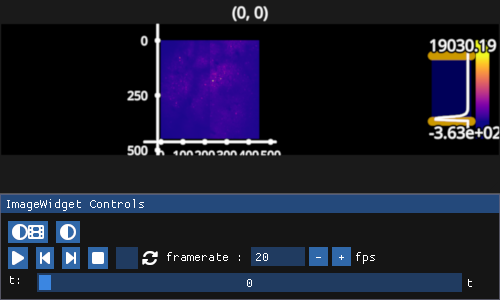

In [15]:
fpl.ImageWidget(data=pmd_obj[:200]).show()